<a href="https://colab.research.google.com/github/filmer2002/RASH_INSPECTOR/blob/master/bodyskin_NASNetMobile_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NASNetMobile**
Let's implement !!!

In [0]:
import tensorflow as tf
import keras
from keras import models
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.nasnet import NASNetMobile
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from vis.utils import utils
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import cv2

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!git clone https://github.com/filmer2002/RASH_INSPECTOR_data

fatal: destination path 'RASH_INSPECTOR_data' already exists and is not an empty directory.


In [0]:
train_path = '/content/RASH_INSPECTOR_data/bodyskin/train'
val_path = '/content/RASH_INSPECTOR_data/bodyskin/val'
test_path = '/content/RASH_INSPECTOR_data/bodyskin/test'

In [0]:
img_size = 224
epochs = 30
batch_size = 32

In [0]:
train_norm = ImageDataGenerator(rescale=1. / 255) 
val_norm = ImageDataGenerator(rescale=1. / 255) 
test_norm = ImageDataGenerator(rescale=1. / 255) 

In [0]:
train_generator = train_norm.flow_from_directory( 
    train_path, 
    target_size=(img_size, img_size), 
    batch_size=batch_size)

val_generator = val_norm.flow_from_directory( 
    val_path, 
    target_size=(img_size, img_size), 
    batch_size=batch_size)

test_generator = test_norm.flow_from_directory( 
    test_path, 
    target_size=(img_size, img_size), 
    batch_size=batch_size,
    shuffle=False)

Found 1520 images belonging to 2 classes.
Found 190 images belonging to 2 classes.
Found 190 images belonging to 2 classes.


In [0]:
num_train_files = len(train_generator.filenames)
num_train_classes = len(train_generator.class_indices)
print('num_train_files', num_train_files, '&', 'num_train_classes', num_train_classes )

num_val_files = len(val_generator.filenames)
num_val_classes = len(val_generator.class_indices)
print('num_val_files', num_val_files, '&', 'num_val_classes', num_val_classes )

num_test_files = len(test_generator.filenames)
num_test_classes = len(test_generator.class_indices)
print('num_test_files', num_test_files, '&', 'num_test_classes', num_test_classes )

num_train_files 1520 & num_train_classes 2
num_val_files 190 & num_val_classes 2
num_test_files 190 & num_test_classes 2


In [0]:
train_steps = np.ceil(num_train_files/batch_size)
val_steps = np.ceil(num_val_files/batch_size)

In [0]:
model = NASNetMobile(weights='imagenet')

In [0]:
x = model.layers[-2].output
predictions = Dense(num_train_classes, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)

In [0]:
x = model.layers[-2].output
predictions = Dense(num_train_classes, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [0]:
model.compile(Adam(lr=0.01), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
model_path = '/content/drive/My Drive/โครงงานผื่น/RASH_INSPECTOR/ORGAN/bodyskin/NASNetMobile/bodyskin_nasnsetmobile_model.h5'

In [0]:
checkpoint = ModelCheckpoint(model_path, monitor='val_acc', verbose=1,
                             save_best_only=True, mode='max')

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

In [0]:
log_dir = '/content/drive/My Drive/โครงงานผื่น/RASH_INSPECTOR/ORGAN/bodyskin/NASNetMobile/tf-log/'
tb_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

In [0]:
cb_list = [checkpoint, early_stop, reduce_lr, tb_cb]

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps,
                              validation_data=val_generator,
                              validation_steps=val_steps,
                              epochs=epochs,
                              verbose=1,
                              callbacks=cb_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/30
48/48 [==============================] - 105s 2s/step - loss: 0.6338 - acc: 0.6973 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to /content/drive/My Drive/โครงงานผื่น/RASH_INSPECTOR/ORGAN/bodyskin/NASNetMobile/bodyskin_nasnsetmobile_model.h5

Epoch 2/30
48/48 [==============================] - 42s 884ms/step - loss: 0.4063 - acc: 0.8138 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/30
48/48 [==============================] - 42s 879ms/step - loss: 0.5021 - acc: 0.8170 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00003: val_acc did not improve from 0.50000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 4/30
48/48 [==============================] - 42s 873ms/step - loss: 0.5490 - acc: 0.7585 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 0

In [0]:
model.save_weights('/content/drive/My Drive/โครงงานผื่น/RASH_INSPECTOR/ORGAN/bodyskin/NASNetMobile/bodyskin_nasnetmobile_weights.h5')

In [0]:
model.load_weights(model_path)

val_loss, val_acc = \
model.evaluate_generator(test_generator, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.3976730575294871
val_acc: 0.8315789473684211


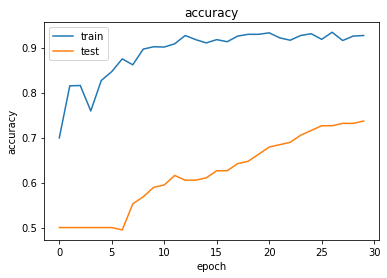

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title('accuracy')
plt.show()

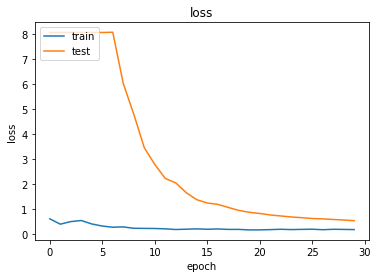

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.title('loss')
plt.show()

In [0]:
Y_pred = model.predict_generator(test_generator, num_test_files//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
classes_names = ['AD', 'Other']
print(classification_report(test_generator.classes, y_pred, target_names=classes_names))

Confusion Matrix
[[63 32]
 [ 0 95]]
Classification Report
              precision    recall  f1-score   support

          AD       1.00      0.66      0.80        95
       Other       0.75      1.00      0.86        95

    accuracy                           0.83       190
   macro avg       0.87      0.83      0.83       190
weighted avg       0.87      0.83      0.83       190



In [0]:
predictions = model.predict_generator(test_generator, steps=val_steps, verbose=1)

6/6 [==============================] - 1s 176ms/step


In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
cm_plot_labels = ['AD', 'Other']

Confusion matrix, without normalization
[[63 32]
 [ 0 95]]


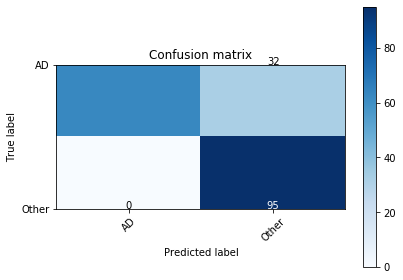

In [0]:
cm = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
plot_confusion_matrix(cm, cm_plot_labels)